# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [12]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install tqdm
import math
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm

path = "data"

# Processing and cleaning data 
The data processing pipeline handles multiple vehicle listings datasets scraped from Craigslist across different dates. The implementation addresses several key challenges:

### Missing Posting Dates
Earlier datasets lacked posting dates, so the scrape date from the filename (`vehicles-YYYY-MM-DD.csv`) is used instead. This enables the calculation of car age and its impact on pricing.

### Memory Management 
Due to dataset size, a custom normalizer processes files individually rather than combining them. The code:
- Removes rows with excessive missing values
- Imputes missing data using similar vehicle records
- Processes files in chunks to maintain memory efficiency

### Feature Handling
The `DataNormalizer` class manages:
- Ordinal features (size, condition, cylinders)
- Categorical features (fuel type, transmission, etc.)
- Numeric features (price, year, odometer)
- Missing value imputation based on manufacturer/model patterns

This approach allows analysis of large-scale vehicle data while maintaining consistent normalization across multiple datasets, enabling investigation of pricing trends over time.

In [2]:
def process_all_vehicle_files(folder_path):
    print(f"Processing all vehicle files in folder: {folder_path}")
    
    file_paths = glob(os.path.join(folder_path, "vehicles*.csv"))
    
    if not file_paths:
        print("No files found in the folder matching the pattern 'vehicles*.csv'.")
        return
    
    for idx, file_path in enumerate(file_paths, 1):
        print(f"Processing file {idx}/{len(file_paths)}: {os.path.basename(file_path)}")
        try:
            process_and_clean_single_vehicle_file(file_path)
            print(f"File {idx} processed successfully.")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    print("All files in the folder have been processed.")

def process_and_clean_single_vehicle_file(file_path):
    file_name = os.path.basename(file_path)
    parts = file_name.replace('.csv', '').split('-')
    
    if len(parts) >= 3:
        year = parts[-1]
        month = parts[-2]
        default_posting_date = f"{year}-{month}-01"
    else:
        default_posting_date = None  
    
    print(f"Reading file: {file_name}")
    df = pd.read_csv(file_path)
    
    if 'posting_date' not in df.columns:
        df['posting_date'] = default_posting_date
    
    print("Cleaning and normalizing data...")
    cleaned_df = clean_car_data(df)
    
    print("Adding car age column...")
    cleaned_df = add_car_age(cleaned_df)
    
    cleaned_df['posting_date'] = pd.to_datetime(cleaned_df['posting_date'], errors='coerce')
    earliest_date = cleaned_df['posting_date'].min().strftime('%Y-%m-%d') if not cleaned_df['posting_date'].isna().all() else 'unknown'
    latest_date = cleaned_df['posting_date'].max().strftime('%Y-%m-%d') if not cleaned_df['posting_date'].isna().all() else 'unknown'
    
    output_file_name = f"cleaned-vehicles-{earliest_date}-{latest_date}.csv"
    output_path = os.path.join(os.path.dirname(file_path), output_file_name)
    
    print(f"Writing cleaned data to: {output_file_name}")
    cleaned_df.to_csv(output_path, index=False)
    print("Processing and cleaning complete.")


def clean_car_data(df):
    
    cleaned_df = df.copy()
    
    cleaned_df['posting_year'] = cleaned_df['posting_date'].str[:4].astype(float)
    
    ignore_columns = ['long', 'lat', 'image_url', 'region', 'region_url', 'county', 'state']
    
    columns_to_check = [col for col in cleaned_df.columns if col not in ignore_columns]
    
    rows_to_keep = cleaned_df[columns_to_check].isnull().sum(axis=1) <= 2
    cleaned_df = cleaned_df[rows_to_keep]
    
    def fill_missing_value(row, column):
        if pd.isnull(row[column]):
            
            similar_cars = cleaned_df[
                (cleaned_df['year'] == row['year']) &
                (cleaned_df['manufacturer'] == row['manufacturer']) &
                (cleaned_df['model'] == row['model']) &
                (cleaned_df['posting_year'] == row['posting_year']) &
                (~pd.isnull(cleaned_df[column]))
            ]
            
            if len(similar_cars) >= 3:  
                return similar_cars[column].median()
            
            similar_cars = cleaned_df[
                (cleaned_df['year'] == row['year']) &
                (cleaned_df['manufacturer'] == row['manufacturer']) &
                (cleaned_df['posting_year'] == row['posting_year']) &
                (~pd.isnull(cleaned_df[column]))
            ]
            
            if len(similar_cars) >= 3:
                return similar_cars[column].median()
            
            return cleaned_df[
                (cleaned_df['year'] == row['year']) &
                (~pd.isnull(cleaned_df[column]))
            ][column].median()
    
    numeric_columns = ['odometer', 'price'] 
    for column in numeric_columns:
        mask = cleaned_df[column].isnull()
        cleaned_df.loc[mask, column] = cleaned_df[mask].apply(
            lambda row: fill_missing_value(row, column), axis=1
        )
    
    return cleaned_df

def add_car_age(df):
    df = df.copy()
    
    df['car_age'] = df['posting_year'] - df['year']
    
    return df


class DataNormalizer:
    def __init__(self):
        # Ordinal mappings
        self.size_order = {
            'sub-compact': 0,
            'compact': 1,
            'mid-size': 2,
            'full-size': 3
        }
        
        self.cylinder_order = {
            'other': 0,
            '3 cylinders': 3,
            '4 cylinders': 4,
            '5 cylinders': 5,
            '6 cylinders': 6,
            '8 cylinders': 8,
            '10 cylinders': 10,
            '12 cylinders': 12
        }
        
        self.condition_order = {
            'salvage': 0,
            'fair': 1,
            'good': 2,
            'excellent': 3,
            'like new': 4,
            'new': 5
        }
        
        self.size_reverse = {v: k for k, v in self.size_order.items()}
        self.cylinder_reverse = {v: k for k, v in self.cylinder_order.items()}
        self.condition_reverse = {v: k for k, v in self.condition_order.items()}
        
        self.numeric_params = {}
        self.categorical_mappings = {}
        
        self.model_cylinders_map = {}
        self.manufacturer_cylinders_map = {}
        self.manufacturer_model_map = {}
        self.most_common_cylinders = None
        self.most_common_model = None
        
        self.numeric_cols = ['price', 'year', 'odometer']
        self.categorical_cols = [
            'fuel', 'title_status', 'transmission', 
            'drive', 'type', 'state', 'county'
        ]
        self.encode_only_cols = ['paint_color', 'region', 'manufacturer', 'model']

    def fit(self, file_paths):
        print("Calculating normalization parameters and imputation mappings...")
        
        numeric_mins = {col: float('inf') for col in self.numeric_cols}
        numeric_maxs = {col: float('-inf') for col in self.numeric_cols}
        
        categorical_values = {col: set() for col in self.categorical_cols}
        encode_only_values = {col: set() for col in self.encode_only_cols}
        
       
        model_cylinders_count = {}      
        manufacturer_cylinders_count = {} 
        manufacturer_model_count = {}    
        cylinders_count = {}           
        model_count = {}                
        
       
        for file_path in file_paths:
            print(f"Processing {os.path.basename(file_path)}...")
            
            chunk_size = 10000
            for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                for col in self.numeric_cols:
                    if col in chunk.columns:
                        chunk_min = chunk[col].dropna().min()
                        chunk_max = chunk[col].dropna().max()
                        if not pd.isna(chunk_min) and not pd.isna(chunk_max):
                            numeric_mins[col] = min(numeric_mins[col], chunk_min)
                            numeric_maxs[col] = max(numeric_maxs[col], chunk_max)
                
                for col in self.categorical_cols:
                    if col in chunk.columns:
                        categorical_values[col].update(chunk[col].dropna().unique())
                
                for col in self.encode_only_cols:
                    if col in chunk.columns:
                        encode_only_values[col].update(chunk[col].dropna().unique())
                
                valid_rows = chunk[['manufacturer', 'model', 'cylinders']].dropna(subset=['manufacturer'])
                
                for _, row in valid_rows.iterrows():
                    mfr = row['manufacturer']
                    model = row['model']
                    cyls = row['cylinders']
                    
                    if pd.notna(model) and pd.notna(cyls):
                        if model not in model_cylinders_count:
                            model_cylinders_count[model] = {}
                        model_cylinders_count[model][cyls] = model_cylinders_count[model].get(cyls, 0) + 1
                    
                    if pd.notna(cyls):
                        if mfr not in manufacturer_cylinders_count:
                            manufacturer_cylinders_count[mfr] = {}
                        manufacturer_cylinders_count[mfr][cyls] = manufacturer_cylinders_count[mfr].get(cyls, 0) + 1
                        cylinders_count[cyls] = cylinders_count.get(cyls, 0) + 1
                    
                    if pd.notna(model):
                        if mfr not in manufacturer_model_count:
                            manufacturer_model_count[mfr] = {}
                        manufacturer_model_count[mfr][model] = manufacturer_model_count[mfr].get(model, 0) + 1
                        model_count[model] = model_count.get(model, 0) + 1
        
        for col in self.numeric_cols:
            if numeric_mins[col] < numeric_maxs[col]:
                self.numeric_params[col] = {
                    'min': numeric_mins[col],
                    'max': numeric_maxs[col]
                }
        
        for col in self.categorical_cols:
            if categorical_values[col]:
                sorted_values = sorted(categorical_values[col])
                mapping = {val: idx for idx, val in enumerate(sorted_values)}
                reverse_mapping = {idx: val for val, idx in mapping.items()}
                self.categorical_mappings[col] = {
                    'mapping': mapping,
                    'reverse_mapping': reverse_mapping,
                    'max': len(mapping) - 1
                }
        
        for col in self.encode_only_cols:
            if encode_only_values[col]:
                sorted_values = sorted(encode_only_values[col])
                mapping = {val: idx for idx, val in enumerate(sorted_values)}
                reverse_mapping = {idx: val for val, idx in mapping.items()}
                self.categorical_mappings[col] = {
                    'mapping': mapping,
                    'reverse_mapping': reverse_mapping
                }
        for model, cyls_dict in model_cylinders_count.items():
            self.model_cylinders_map[model] = max(cyls_dict.items(), key=lambda x: x[1])[0]
        
        for mfr, cyls_dict in manufacturer_cylinders_count.items():
            self.manufacturer_cylinders_map[mfr] = max(cyls_dict.items(), key=lambda x: x[1])[0]
        
        for mfr, model_dict in manufacturer_model_count.items():
            self.manufacturer_model_map[mfr] = max(model_dict.items(), key=lambda x: x[1])[0]
        
        if cylinders_count:
            self.most_common_cylinders = max(cylinders_count.items(), key=lambda x: x[1])[0]
        if model_count:
            self.most_common_model = max(model_count.items(), key=lambda x: x[1])[0]
        
        print("Normalization parameters and imputation mappings calculated.")
        
        print("\nEncoding ranges:")
        for col in self.encode_only_cols:
            if col in self.categorical_mappings:
                n_values = len(self.categorical_mappings[col]['mapping'])
                print(f"{col}: 0 to {n_values - 1} ({n_values} unique values)")

    def normalize(self, df):
        if not self.numeric_params and not self.categorical_mappings:
            raise ValueError("Normalizer has not been fitted. Call fit() first.")
            
        df_norm = df.copy()
        
        mask = df_norm['cylinders'].isna()
        if mask.any():
            for idx in df_norm[mask].index:
                model = df_norm.loc[idx, 'model']
                manufacturer = df_norm.loc[idx, 'manufacturer']
                
                if pd.notna(model) and model in self.model_cylinders_map:
                    df_norm.loc[idx, 'cylinders'] = self.model_cylinders_map[model]
                elif pd.notna(manufacturer) and manufacturer in self.manufacturer_cylinders_map:
                    df_norm.loc[idx, 'cylinders'] = self.manufacturer_cylinders_map[manufacturer]
                elif self.most_common_cylinders is not None:
                    df_norm.loc[idx, 'cylinders'] = self.most_common_cylinders
        
        mask = df_norm['model'].isna()
        if mask.any():
            for idx in df_norm[mask].index:
                manufacturer = df_norm.loc[idx, 'manufacturer']
                
                if pd.notna(manufacturer) and manufacturer in self.manufacturer_model_map:
                    df_norm.loc[idx, 'model'] = self.manufacturer_model_map[manufacturer]
                elif self.most_common_model is not None:
                    df_norm.loc[idx, 'model'] = self.most_common_model
        
        for col in self.numeric_cols:
            if col in df_norm.columns and col in self.numeric_params:
                params = self.numeric_params[col]
                df_norm[col] = (df_norm[col] - params['min']) / (params['max'] - params['min'])
        
        if 'size' in df_norm.columns:
            df_norm['size'] = df_norm['size'].map(self.size_order)
            size_max = max(self.size_order.values())
            df_norm['size'] = df_norm['size'] / size_max
        
        if 'cylinders' in df_norm.columns:
            df_norm['cylinders'] = df_norm['cylinders'].map(self.cylinder_order)
            cylinder_max = max(self.cylinder_order.values())
            df_norm['cylinders'] = df_norm['cylinders'] / cylinder_max
        
        if 'condition' in df_norm.columns:
            df_norm['condition'] = df_norm['condition'].map(self.condition_order)
            condition_max = max(self.condition_order.values())
            df_norm['condition'] = df_norm['condition'] / condition_max
        
        for col in self.categorical_cols:
            if col in df_norm.columns and col in self.categorical_mappings:
                mapping = self.categorical_mappings[col]['mapping']
                max_val = self.categorical_mappings[col]['max']
                df_norm[col] = df_norm[col].map(mapping) / max_val
        
        for col in self.encode_only_cols:
            if col in df_norm.columns and col in self.categorical_mappings:
                mapping = self.categorical_mappings[col]['mapping']
                df_norm[col] = df_norm[col].map(mapping)
        
        return df_norm

    def denormalize(self, df_norm):
        if not self.numeric_params and not self.categorical_mappings:
            raise ValueError("Normalizer has not been fitted. Call fit() first.")
            
        df_denorm = df_norm.copy()
        
        for col in self.numeric_cols:
            if col in df_denorm.columns and col in self.numeric_params:
                params = self.numeric_params[col]
                df_denorm[col] = df_denorm[col] * (params['max'] - params['min']) + params['min']
        
        if 'size' in df_denorm.columns:
            size_max = max(self.size_order.values())
            df_denorm['size'] = (df_denorm['size'] * size_max).round()
            df_denorm['size'] = df_denorm['size'].map(self.size_reverse)
        
        if 'cylinders' in df_denorm.columns:
            cylinder_max = max(self.cylinder_order.values())
            df_denorm['cylinders'] = (df_denorm['cylinders'] * cylinder_max).round()
            df_denorm['cylinders'] = df_denorm['cylinders'].map(self.cylinder_reverse)
        
        if 'condition' in df_denorm.columns:
            condition_max = max(self.condition_order.values())
            df_denorm['condition'] = (df_denorm['condition'] * condition_max).round()
            df_denorm['condition'] = df_denorm['condition'].map(self.condition_reverse)
        
        for col in self.categorical_cols:
            if col in df_denorm.columns and col in self.categorical_mappings:
                max_val = self.categorical_mappings[col]['max']
                reverse_mapping = self.categorical_mappings[col]['reverse_mapping']
                df_denorm[col] = (df_denorm[col] * max_val).round()
                df_denorm[col] = df_denorm[col].map(reverse_mapping)
        
        for col in self.encode_only_cols:
            if col in df_denorm.columns and col in self.categorical_mappings:
                reverse_mapping = self.categorical_mappings[col]['reverse_mapping']
                df_denorm[col] = df_denorm[col].round()
                df_denorm[col] = df_denorm[col].map(reverse_mapping)
        
        return df_denorm


# Normalized price data between states
This analysis addresses geographical price variations in the used car market. The implementation calculates state-specific price factors to normalize listing prices across different regions, allowing focus on more actionable features for buyers and sellers.

### Price Factor Calculation
The code employs a two-stage outlier removal process:
- First removes national outliers using IQR method (1.5 * IQR)
- Then removes state-specific outliers using the same approach
- Requires minimum sample sizes (100 initial listings, 50 after cleaning)
- Limits maximum state price deviation to 50% from national average

### Data Requirements
For each state's data to be included:
- Must have at least 100 listings initially
- Must retain at least 50 listings after outlier removal
- Final price factor must be within ±50% of national average

### Implementation Details
The process works in two main steps:
1. Aggregates data from all cleaned CSV files in the input folder
2. Calculates state-specific price factors relative to national average

This normalization enables analysis of other features without geographical price variations skewing the results, providing more relevant insights for individual buyers and sellers.

In [6]:
def find_state_price_factors(input_folder):
    def calculate_state_price_factors(df):
        df_analysis = df.copy()
        
        Q1 = df_analysis['price'].quantile(0.25)
        Q3 = df_analysis['price'].quantile(0.75)
        IQR = Q3 - Q1
        price_lower_bound = Q1 - 1.5 * IQR
        price_upper_bound = Q3 + 1.5 * IQR
        
        df_analysis = df_analysis[
            (df_analysis['price'] >= price_lower_bound) &
            (df_analysis['price'] <= price_upper_bound)
        ]
        
        national_avg = df_analysis['price'].mean()
        
        def get_state_mean_without_outliers(state_data):
            if len(state_data) < 100:  
                return None
                
            Q1 = state_data['price'].quantile(0.25)
            Q3 = state_data['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            clean_state_data = state_data[
                (state_data['price'] >= lower) &
                (state_data['price'] <= upper)
            ]
            
            if len(clean_state_data) < 50: 
                return None
                
            return clean_state_data['price'].mean()
        
        state_stats = []
        
        for state in df_analysis['state'].unique():
            state_data = df_analysis[df_analysis['state'] == state]
            state_mean = get_state_mean_without_outliers(state_data)
            
            if state_mean is not None:
                price_factor = (state_mean / national_avg - 1) * 100
                
                if abs(price_factor) <= 50: 
                    state_stats.append({
                        'state': state,
                        'avg_price': state_mean,
                        'price_factor': price_factor,
                        'listing_count': len(state_data)
                    })
        
        state_stats = pd.DataFrame(state_stats)
        
        state_stats = state_stats.sort_values('price_factor', ascending=False)
        
        state_stats['avg_price'] = state_stats['avg_price'].round(2)
        state_stats['price_factor'] = state_stats['price_factor'].round(2)
        
        return state_stats

    csv_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) 
                 if f.startswith('cleaned-') and f.endswith('.csv')]
    
    aggregated_df = pd.DataFrame()
    for file in csv_files:
        print(f"starting work on {file}") 
        df = pd.read_csv(file)
        aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
    
    state_price_factors = calculate_state_price_factors(aggregated_df)
    
    output_file = os.path.join(input_folder, 'state_price_factors.csv')
    state_price_factors.to_csv(output_file, index=False)
    
    return state_price_factors






# Feature Impact Analysis

This implementation analyzes how different features affect vehicle prices by processing cleaned data files and calculating correlations. The code handles both continuous and categorical variables with specialized binning strategies.

### Core Analysis Process
The `analyze_feature_impacts()` function:
- Normalizes prices using state-specific factors
- Processes data in chunks to manage memory
- Calculates per-model price variations
- Computes feature correlations with price variations

### Binning Strategies
Two specialized binning approaches are implemented:
1. Year binning (`create_year_bins()`):
- 50-year bins before 1950
- 25-year bins until 1975
- 10-year bins until 2000
- 5-year bins until 2015
- 1-year bins for recent years

2. Car age binning (`create_car_age_bins()`):
- Fine granularity (1-year) for newer cars
- Increasing bin sizes for older vehicles
- Maximum bin handles outliers

### Implementation Details
The analysis:
- Excludes features unlikely to affect price (IDs, URLs, etc.)
- Requires minimum sample sizes per model
- Handles missing data with median imputation
- Weights correlations by sample size
- Tracks both impact strength and variation

In [37]:
def analyze_feature_impacts(folder_path, min_samples=50, normalizer=None):
    if normalizer is None:
        normalizer = DataNormalizer()
        file_paths = glob(os.path.join(folder_path, "cleaned-vehicles-*.csv"))
        if file_paths:
            print("Fitting normalizer on all data...")
            normalizer.fit(file_paths)
        else:
            print("No files found for fitting normalizer")
            return None

    exclude_features = [
        'id', 'url', 'region', 'region_url', 'image_url', 'description',
        'manufacturer', 'model', 'VIN', 'posting_date', 'year',
        'state', 'county', 'long', 'lat', 'price'
    ]
    
    try:
        state_factors = pd.read_csv(os.path.join(folder_path, 'state_price_factors.csv'))
        state_factors = dict(zip(state_factors['state'], 
                               1 + state_factors['price_factor'] / 100))
    except:
        print("Warning: Could not load state price factors. Using raw prices.")
        state_factors = None
    
    feature_stats = {}
    total_models = 0
    
    for file_path in glob(os.path.join(folder_path, "cleaned-vehicles-*.csv")):
        print(f"Processing {os.path.basename(file_path)}...")
        
        try:
            chunk_size = 100000
            for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                if state_factors is not None:
                    chunk['normalized_price'] = chunk.apply(
                        lambda row: row['price'] / state_factors.get(row['state'], 1),
                        axis=1
                    )
                else:
                    chunk['normalized_price'] = chunk['price']
                
                features_to_analyze = [col for col in chunk.columns 
                                     if col not in exclude_features]
                
                for model in chunk['model'].unique():
                    if pd.isna(model):
                        continue
                        
                    model_data = chunk[chunk['model'] == model].copy()
                    
                    if len(model_data) < min_samples:
                        continue
                    
                    try:
                        normalized_data = normalizer.normalize(model_data)
                        
                        model_mean_price = normalized_data['normalized_price'].mean()
                        
                        price_variations = (normalized_data['normalized_price'] - model_mean_price) / model_mean_price
                        
                        for feature in features_to_analyze:
                            if feature == 'normalized_price':
                                continue
                                
                            
                            if normalized_data[feature].isna().sum() / len(normalized_data) > 0.2:
                                continue
                            
                            try:
                                correlation = abs(np.corrcoef(
                                    normalized_data[feature].fillna(normalized_data[feature].median()),
                                    price_variations
                                )[0, 1])
                                
                                if not np.isnan(correlation):
                                    if feature not in feature_stats:
                                        feature_stats[feature] = {
                                            'sum_impact': 0,
                                            'sum_weights': 0,
                                            'impact_values': [],
                                            'original_values': set()  
                                        }
                                    
                                    weight = len(model_data)
                                    feature_stats[feature]['sum_impact'] += correlation * weight
                                    feature_stats[feature]['sum_weights'] += weight
                                    feature_stats[feature]['impact_values'].append(correlation)
                                    
                                    feature_stats[feature]['original_values'].update(
                                        model_data[feature].dropna().unique()
                                    )
                                    
                            except (ValueError, TypeError):
                                continue
                        
                        total_models += 1
                        
                    except Exception as e:
                        print(f"Error processing model {model}: {str(e)}")
                        continue
                    
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue
    
    results = []
    for feature, stats in feature_stats.items():
        if stats['sum_weights'] > 0:
            avg_impact = stats['sum_impact'] / stats['sum_weights']
            std_impact = np.std(stats['impact_values'])
            num_models = len(stats['impact_values'])
            
            original_values = list(stats['original_values'])
            if len(original_values) > 0:
                if pd.api.types.is_numeric_dtype(pd.Series(original_values)):
                    value_range = f"{min(original_values):.2f} to {max(original_values):.2f}"
                else:
                    value_range = f"{len(original_values)} unique values"
            else:
                value_range = "N/A"
            
            results.append({
                'feature': feature,
                'impact_strength': avg_impact,
                'std_deviation': std_impact,
                'num_models': num_models,
                'data_points': stats['sum_weights'],
                'value_range': value_range
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('impact_strength', ascending=False)
    
    print(f"\nAnalyzed {total_models} unique models")
    return results_df, normalizer
def create_year_bins(year_series):
    min_year = year_series.min()
    max_year = year_series.max()
    
    bins = []
    current_year = min_year
    
    while current_year < 1950 and current_year < max_year:
        bins.append(current_year)
        current_year += 50
    
    while current_year < 1975 and current_year < max_year:
        bins.append(current_year)
        current_year += 25
    
    while current_year < 2000 and current_year < max_year:
        bins.append(current_year)
        current_year += 10
    
    while current_year < 2015 and current_year < max_year:
        bins.append(current_year)
        current_year += 5
    
    while current_year <= max_year:
        bins.append(current_year)
        current_year += 1
    
    if bins[-1] < max_year:
        bins.append(max_year + 1)
    
    labels = []
    for i in range(len(bins)-1):
        if bins[i+1] - bins[i] == 1:
            labels.append(str(bins[i]))
        else:
            labels.append(f'{bins[i]}-{bins[i+1]-1}')
    
    return bins, labels

def create_car_age_bins(age_series):
    bins = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100, age_series.max() + 1]
    
    labels = []
    for i in range(len(bins)-1):
        if bins[i+1] - bins[i] == 1:
            labels.append(f'{bins[i]} year')
        else:
            labels.append(f'{bins[i]}-{bins[i+1]-1} years')
    
    return bins, labels

def analyze_all_features_price_impact(folder_path="data"):
    analyze_columns = [
        'year', 'condition', 'cylinders', 'fuel', 'odometer',
        'title_status', 'transmission', 'drive', 'size', 'type',
        'paint_color', 'car_age'
    ]
    
    required_columns = ['price', 'model'] + analyze_columns
    
    print("Reading files...")
    combined_df = pd.DataFrame()
    for file in glob(os.path.join(folder_path, "cleaned-vehicles-*.csv")):
        try:
            chunk = pd.read_csv(file, usecols=required_columns)
            combined_df = pd.concat([combined_df, chunk], ignore_index=True)
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
            continue
            
    print(f"Total rows loaded: {len(combined_df):,}")
    
    if len(combined_df) == 0:
        print("No data loaded!")
        return None, None
        
    print("Starting feature analysis...")
    results = {}
    
    for column in analyze_columns:
        try:
            analysis_df = combined_df.dropna(subset=['price', 'model', column])
            
            if len(analysis_df) == 0:
                continue
                
            model_avg_prices = analysis_df.groupby('model')['price'].mean()
            
            analysis_df = analysis_df.merge(
                model_avg_prices.rename('model_avg_price'),
                left_on='model',
                right_index=True
            )
            
            analysis_df['price_variation'] = (
                (analysis_df['price'] - analysis_df['model_avg_price']) / 
                analysis_df['model_avg_price'] * 100
            )
            
            if column == 'year':
                bins = [1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2020, 2025]
                labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
                analysis_df['group'] = pd.cut(analysis_df[column], bins=bins, labels=labels)
            elif column == 'car_age':
                bins = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]
                labels = [
                    '0-1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years',
                    '5-7 years', '7-10 years', '10-15 years', '15-20 years', 
                    '20-30 years', '30-50 years', '50+ years'
                ]
                analysis_df['group'] = pd.cut(analysis_df[column], bins=bins, labels=labels)
            elif column == 'odometer':
                mileage_bins = [0, 5000, 10000, 25000, 50000, 100000, 150000, 200000, 300000, 500000, float('inf')]
                mileage_labels = [
                    'Under 5k', '5k-10k', '10k-25k', '25k-50k', '50k-100k',
                    '100k-150k', '150k-200k', '200k-300k', '300k-500k', 'Over 500k'
                ]
                analysis_df['group'] = pd.cut(
                    analysis_df[column],
                    bins=mileage_bins,
                    labels=mileage_labels
                )
            else:
                analysis_df['group'] = analysis_df[column]
            
            stats = analysis_df.groupby('group').agg({
                'price_variation': 'mean',
                'model': 'count'
            }).rename(columns={
                'price_variation': 'avg_variation',
                'model': 'count'
            })
            
            stats.attrs['feature_type'] = 'temporal' if column in ['year', 'car_age'] else \
                                        'numeric' if column == 'odometer' else 'categorical'
            stats.attrs['feature_name'] = column
            
            results[column] = stats
            print(f"Analyzed {column}: {len(stats)} unique values")
            
        except Exception as e:
            print(f"Error analyzing {column}: {str(e)}")
            continue
    
    return results, None

def analyze_price_variation_by_feature(df, analyzed_column):
    clean_df = df.dropna(subset=['price', 'model', analyzed_column])
    
    model_avg_prices = clean_df.groupby('model')['price'].mean()
    
    clean_df = clean_df.merge(
        model_avg_prices.rename('model_avg_price'),
        left_on='model',
        right_index=True
    )
    
    clean_df['price_variation'] = (
        (clean_df['price'] - clean_df['model_avg_price']) / 
        clean_df['model_avg_price'] * 100
    )
    
    results = clean_df.groupby(analyzed_column).agg({
        'price_variation': [
            ('avg_price_variation_pct', 'mean'),
            ('std_deviation_pct', 'std')
        ],
        'model': ('unique_models', 'nunique'),
        'price': ('total_listings', 'count')
    })
    
    results.columns = results.columns.get_level_values(1)
    
    results['std_deviation_pct'] = results['std_deviation_pct'].fillna(0)
    
    results = results.round(2)
    
    results['percent_of_data'] = (
        results['total_listings'] / results['total_listings'].sum() * 100
    ).round(2)
    
    results = results.sort_values(
        'avg_price_variation_pct',
        key=abs,
        ascending=False
    )
    
    return results

# Data Visualization

This implementation provides a comprehensive set of visualization functions to analyze vehicle pricing patterns across different dimensions.

### State Price Visualization
`visualize_state_prices()` creates a two-panel figure showing:
- Bar plot of state-by-state price differences from national average
- Text summary with key statistics and extremes
- Highlights top/bottom 3 states by price factor

### Feature Impact Visualization
Two complementary approaches:
1. `visualize_feature_impacts()`:
- Horizontal bar chart of feature impact strengths
- Filters by minimum model count
- Includes impact strength labels
- Uses consistent color scheme

2. `visualize_feature_analysis()`:
- Individual plots for each feature
- Color-coded bars (red for negative, blue for positive impacts)
- Customized titles and axes
- Optional output to files
- Handles temporal and categorical features

### Summary Visualization
`create_feature_summary_plot()` provides:
- Horizontal bar chart of maximum impact per feature
- Formatted feature names
- Percentage labels
- Grid overlay for readability

The visualization suite enables both detailed analysis of individual factors and high-level comparison of feature impacts on vehicle prices.

In [31]:

def visualize_state_prices(filename='state_price_factors.csv'):
    try:
        df = pd.read_csv(filename)
        
        df = df.sort_values('price_factor')
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
        
        sns.barplot(data=df, x='state', y='price_factor', ax=ax1)
        ax1.set_title('State Price Differences from National Average')
        ax1.set_xlabel('State')
        ax1.set_ylabel('Price Difference (%)')
        ax1.tick_params(axis='x', rotation=45)
        
        ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
        
        summary_text = (
            f"Summary Statistics:\n"
            f"Number of states: {len(df)}\n"
            f"Price factor range: {df['price_factor'].min():.1f}% to {df['price_factor'].max():.1f}%\n"
            f"Total listings analyzed: {df['listing_count'].sum():,}\n\n"
            f"Top 3 most expensive states:\n"
            + "\n".join(f"{state}: +{factor:.1f}%" 
                       for state, factor in df.nlargest(3, 'price_factor')[['state', 'price_factor']].values)
            + "\n\nTop 3 least expensive states:\n"
            + "\n".join(f"{state}: {factor:.1f}%" 
                       for state, factor in df.nsmallest(3, 'price_factor')[['state', 'price_factor']].values)
        )
        
        ax2.text(0.05, 0.95, summary_text, 
                transform=ax2.transAxes, 
                verticalalignment='top',
                fontfamily='monospace')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except FileNotFoundError:
        print(f"Error: Could not find file {filename}")
    except Exception as e:
        print(f"Error visualizing data: {str(e)}")
        
def visualize_feature_impacts(impact_df, min_models=10):
    
    plot_df = pd.DataFrame({
        'feature': impact_df.feature,
        'impact_strength': impact_df.impact_strength,
        'std_deviation': impact_df.std_deviation,
        'num_models': impact_df.num_models,
        'data_points': impact_df.data_points
    })
    
    plot_df = plot_df[plot_df['num_models'] >= min_models].copy()
    
    if len(plot_df) == 0:
        print(f"No features found with at least {min_models} models")
        return
    
    plot_df = plot_df.sort_values('impact_strength', ascending=True)
    
    plt.figure(figsize=(12, 8))
    
    sns.barplot(data=plot_df,
                y='feature',
                x='impact_strength',
                color='skyblue',
                orient='h')
    
    plt.title('Feature Impact on Car Prices', fontsize=14, pad=20)
    plt.xlabel('Impact Strength (0-1)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(plot_df['impact_strength']):
        plt.text(v + 0.01, i, f'{v:.3f}', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    
    plt.show()

def visualize_feature_analysis(results, output_folder=None):

    if not results:
        print("No results to visualize")
        return
        
    plt.style.use('default')
    
    feature_titles = {
        'year': 'Model Year Impact on Price',
        'car_age': 'Car Age Impact on Price',
        'condition': 'Vehicle Condition Impact on Price',
        'cylinders': 'Engine Size Impact on Price',
        'fuel': 'Fuel Type Impact on Price',
        'odometer': 'Mileage Impact on Price',
        'title_status': 'Title Status Impact on Price',
        'transmission': 'Transmission Type Impact on Price',
        'drive': 'Drive Type Impact on Price',
        'size': 'Vehicle Size Impact on Price',
        'type': 'Vehicle Type Impact on Price',
        'paint_color': 'Color Impact on Price'
    }
    
    for feature, data in results.items():
        try:
            plt.figure(figsize=(12, 6))
            
            sorted_data = data.sort_values('avg_variation')
            variations = sorted_data['avg_variation']
            
            colors = ['#DB4437' if x < 0 else '#4285F4' for x in variations]
            plt.bar(range(len(variations)), variations, color=colors)
            
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
            
            plt.title(feature_titles.get(feature, f'{feature.replace("_", " ").title()} Impact on Price'),
                     pad=20, fontsize=12, fontweight='bold')
            plt.ylabel('Price Difference (%)')
            
            plt.xticks(range(len(sorted_data)), 
                      sorted_data.index,
                      rotation=45,
                      ha='right')
            
            plt.grid(True, axis='y', alpha=0.2, linestyle='--')
            
            plt.tight_layout()
            
            if output_folder:
                os.makedirs(output_folder, exist_ok=True)
                plt.savefig(os.path.join(output_folder, f'{feature}_analysis.png'), 
                           bbox_inches='tight', dpi=300)
                plt.close()
            else:
                plt.show()
                
        except Exception as e:
            print(f"Error visualizing {feature}: {str(e)}")
            plt.close()
            continue
            
def create_feature_summary_plot(summary_df):
   
    if summary_df is None or len(summary_df) == 0:
        print("No summary data to visualize")
        return
        
    plt.figure(figsize=(12, 6))
    
    bars = plt.barh(range(len(summary_df)), summary_df['max_impact'],
                   alpha=0.6,
                   color='skyblue')
    
    plt.yticks(range(len(summary_df)), 
              [f.replace('_', ' ').title() for f in summary_df['feature']])
    plt.xlabel('Maximum Price Impact (%)')
    plt.title('Summary of Feature Impacts on Price', pad=20)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f' {width:.1f}%',
                va='center')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Workflow
The following is the workflow we used for processing the datasets.
1. Preprocess files into being smaller, add some valuable columns. We could afford to remove nearly half of the data from every dataset, as there was more than enough data for model training and making deductions. Fit normalizer.
2. Get the state price factor.
3. Calculate specific values.
4. Visualize values

In [9]:
#process_all_vehicle_files(path) # needed if working with raw data
normalizer = DataNormalizer()
file_paths = glob(os.path.join(path, "cleaned-vehicles-*.csv"))
normalizer.fit(file_paths)

Calculating normalization parameters and imputation mappings...
Processing cleaned-vehicles-2020-03-01-2020-03-01.csv...
Processing cleaned-vehicles-2020-06-01-2020-06-01.csv...
Processing cleaned-vehicles-2020-09-01-2020-09-01.csv...
Processing cleaned-vehicles-2020-10-28-2020-12-03.csv...
Processing cleaned-vehicles-2021-04-01-2021-04-01.csv...
Processing cleaned-vehicles-2021-04-04-2021-05-04.csv...
Normalization parameters and imputation mappings calculated.

Encoding ranges:
paint_color: 0 to 11 (12 unique values)
region: 0 to 403 (404 unique values)
manufacturer: 0 to 43 (44 unique values)
model: 0 to 54412 (54413 unique values)


In [10]:
state_price_factors = find_state_price_factors(path)

starting work on data\cleaned-vehicles-2020-03-01-2020-03-01.csv
starting work on data\cleaned-vehicles-2020-06-01-2020-06-01.csv
starting work on data\cleaned-vehicles-2020-09-01-2020-09-01.csv
starting work on data\cleaned-vehicles-2020-10-28-2020-12-03.csv
starting work on data\cleaned-vehicles-2021-04-01-2021-04-01.csv
starting work on data\cleaned-vehicles-2021-04-04-2021-05-04.csv


In [ ]:
model_correlations, normalizer = analyze_feature_impacts("data", normalizer=normalizer)
results, summary = analyze_all_features_price_impact()

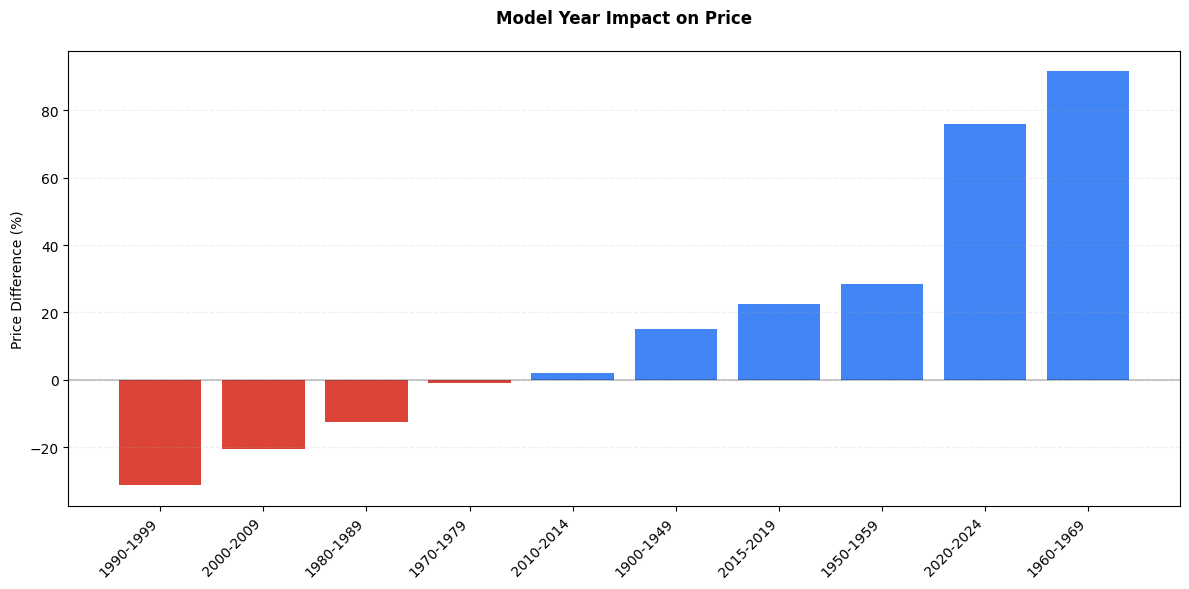

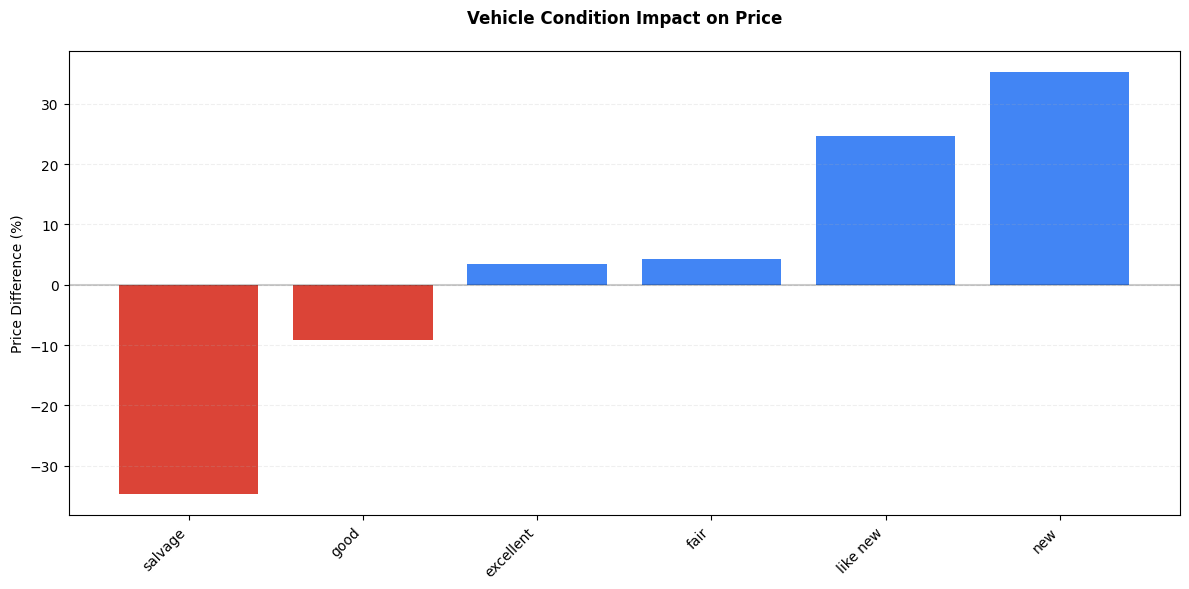

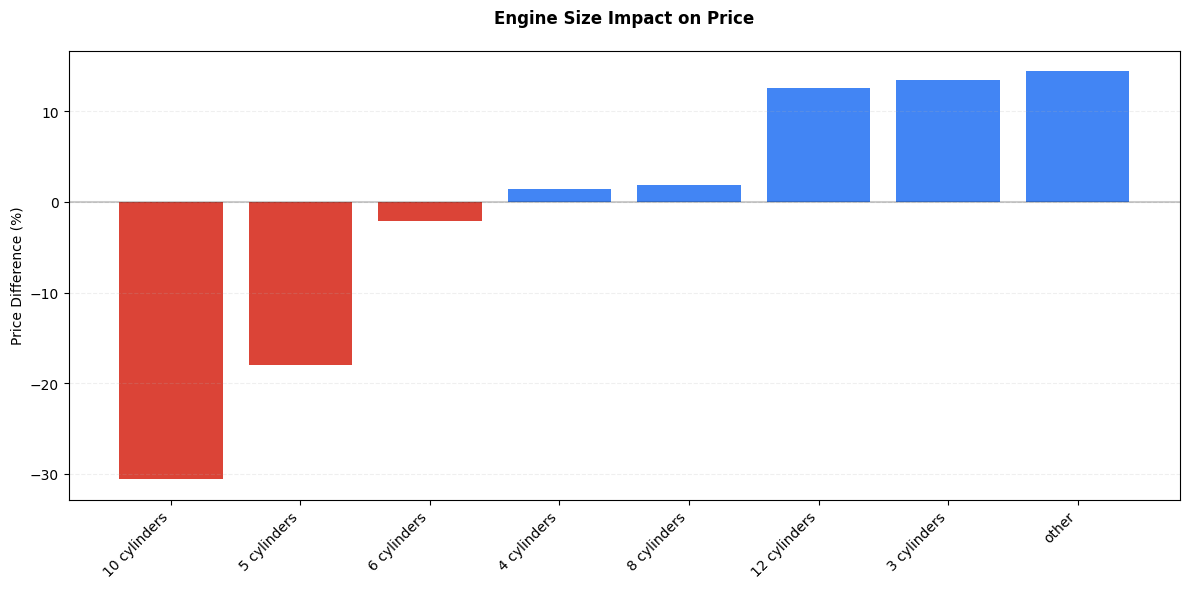

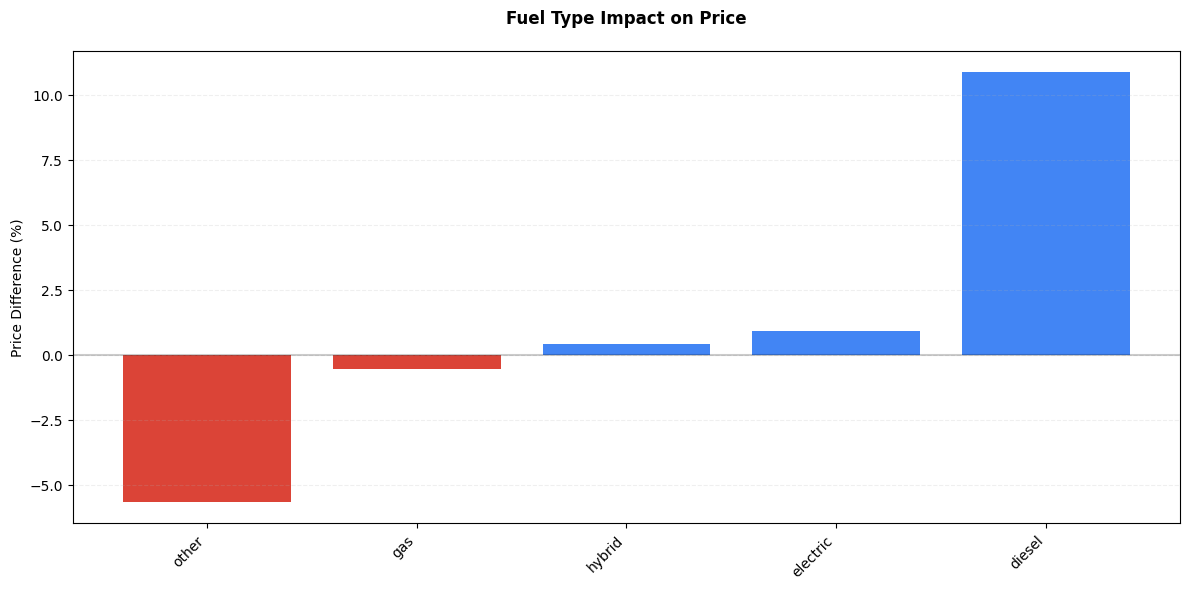

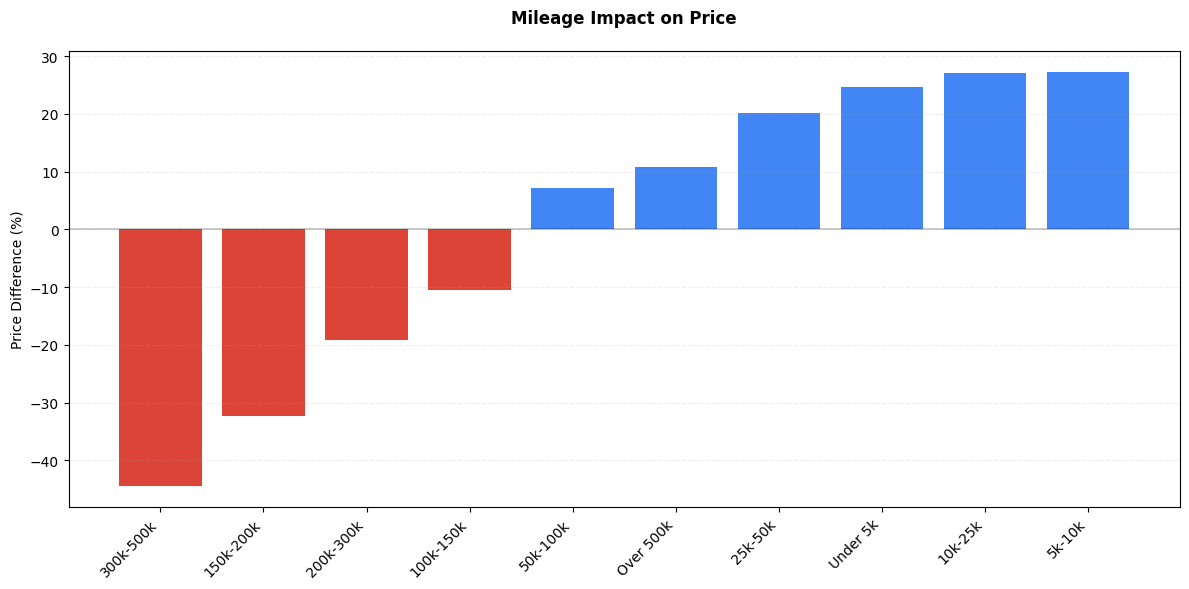

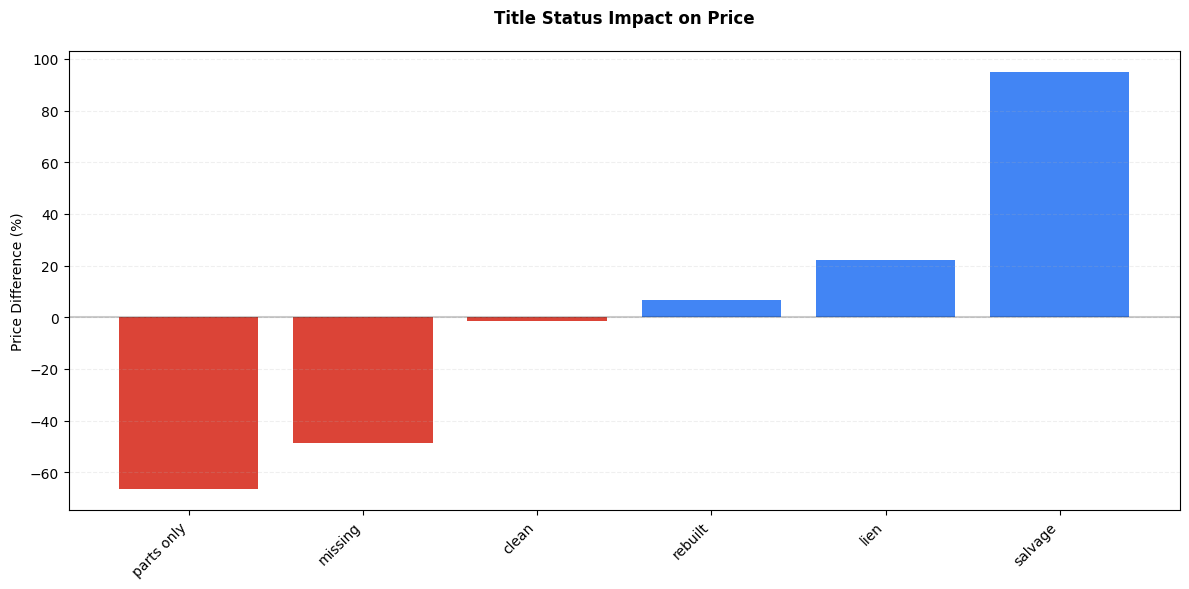

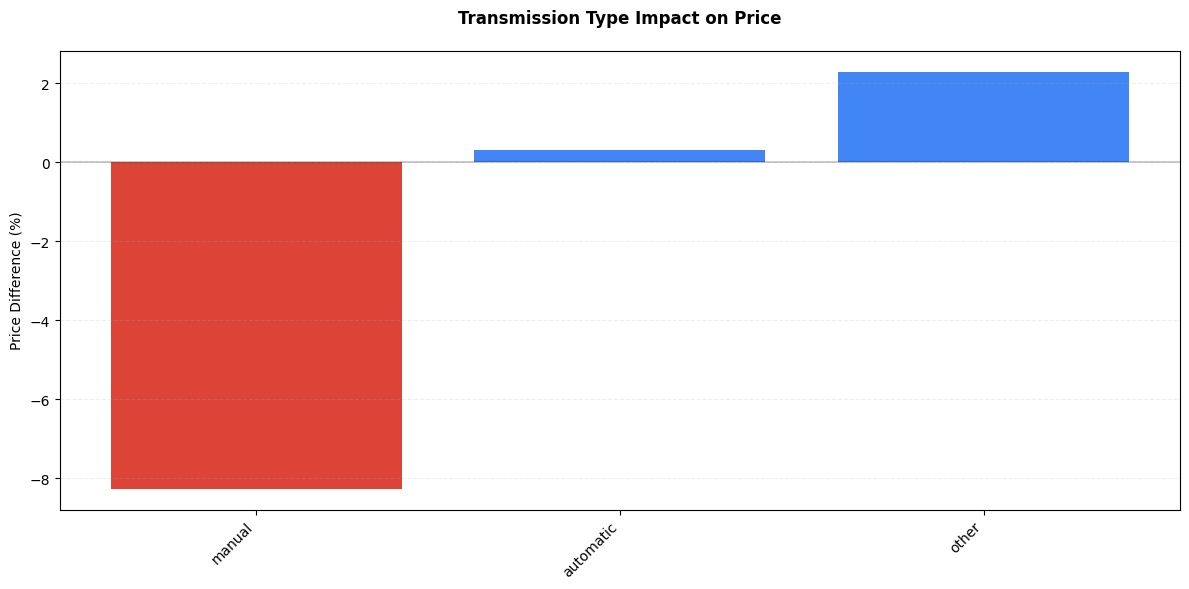

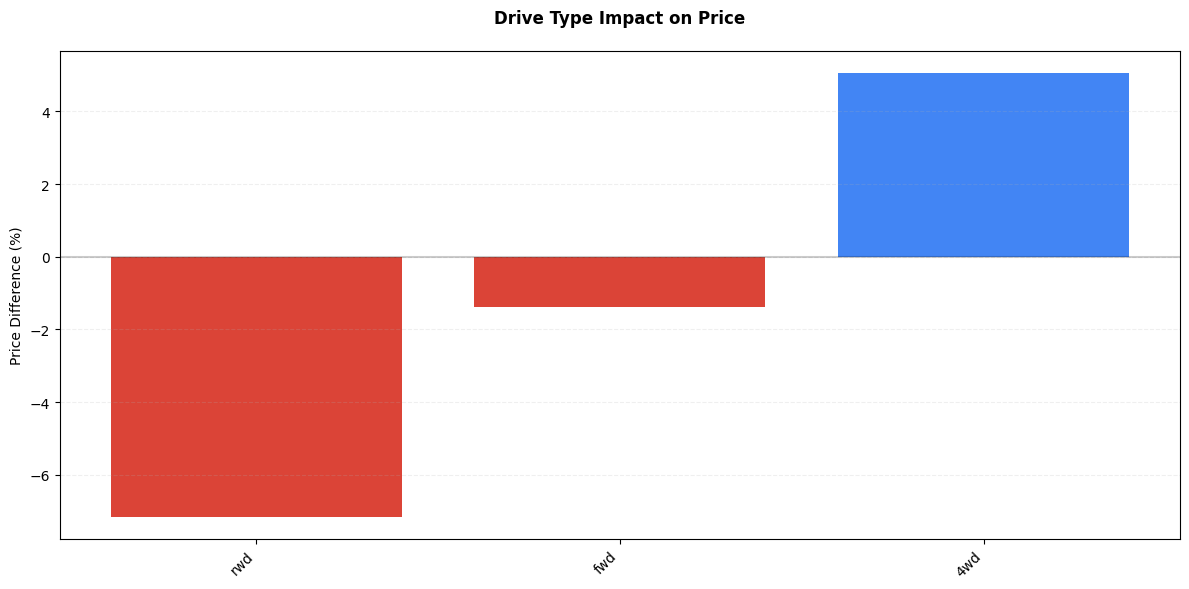

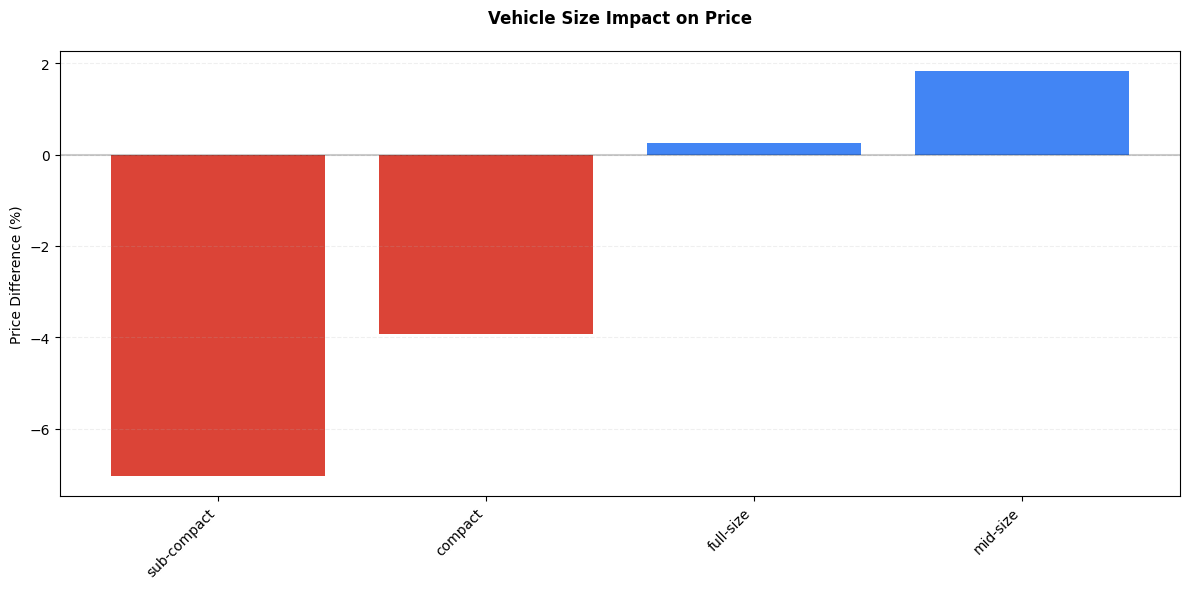

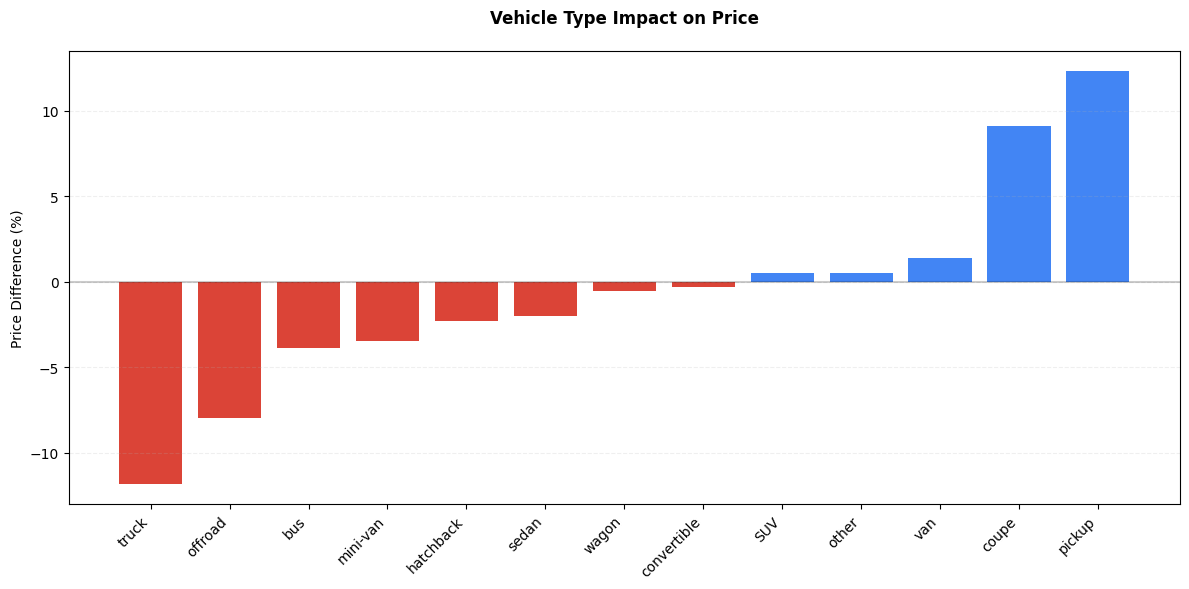

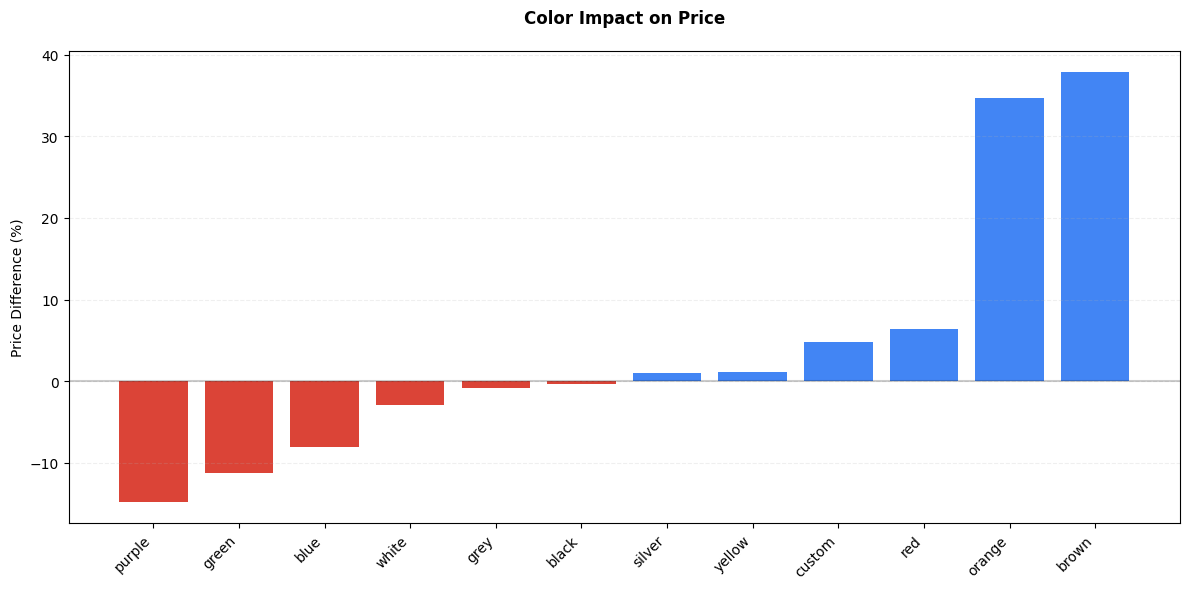

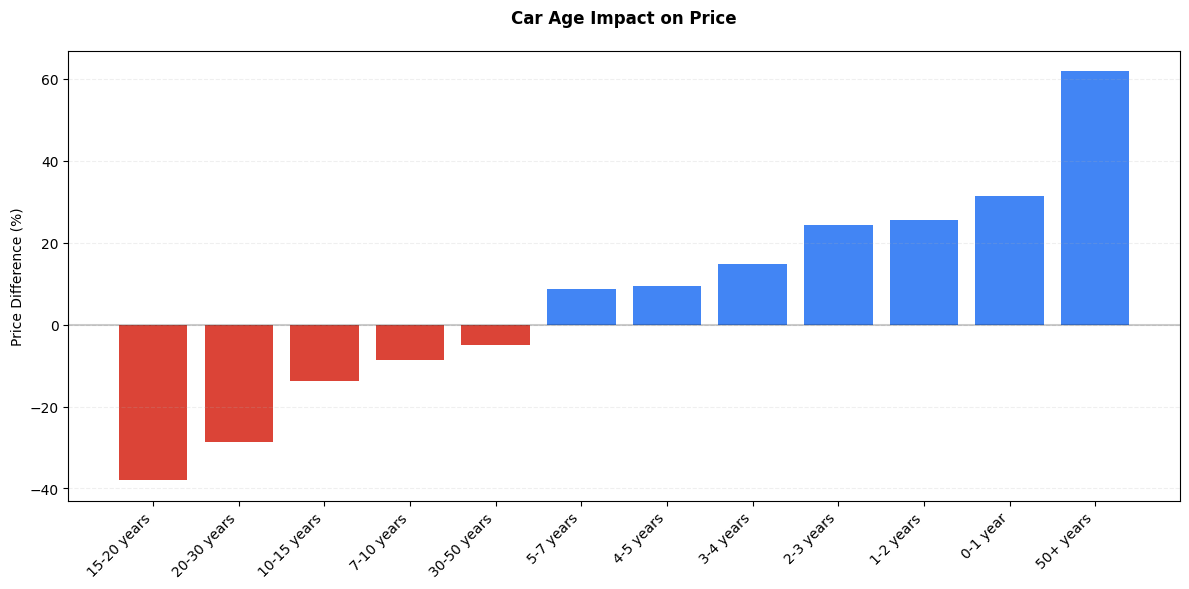

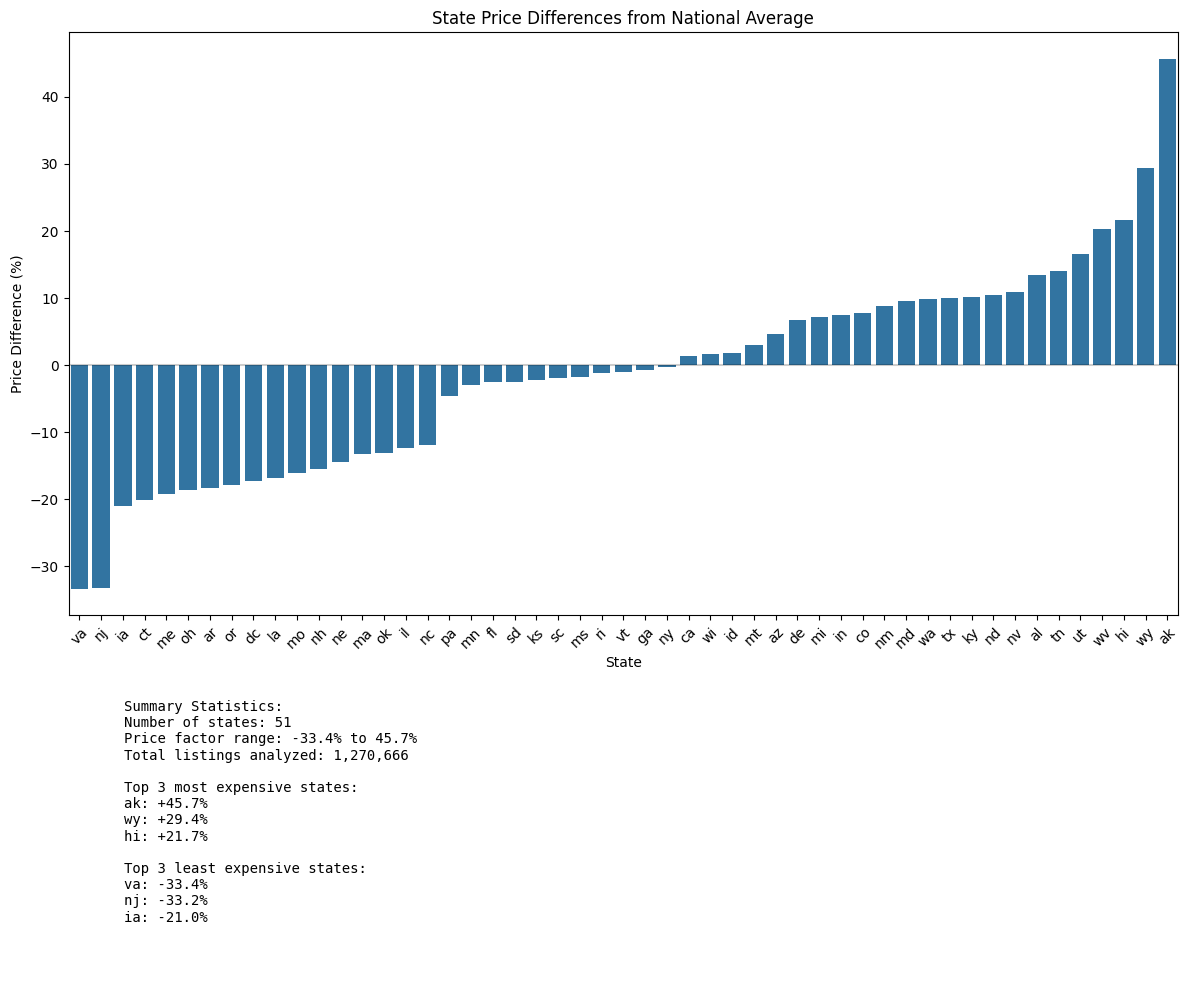

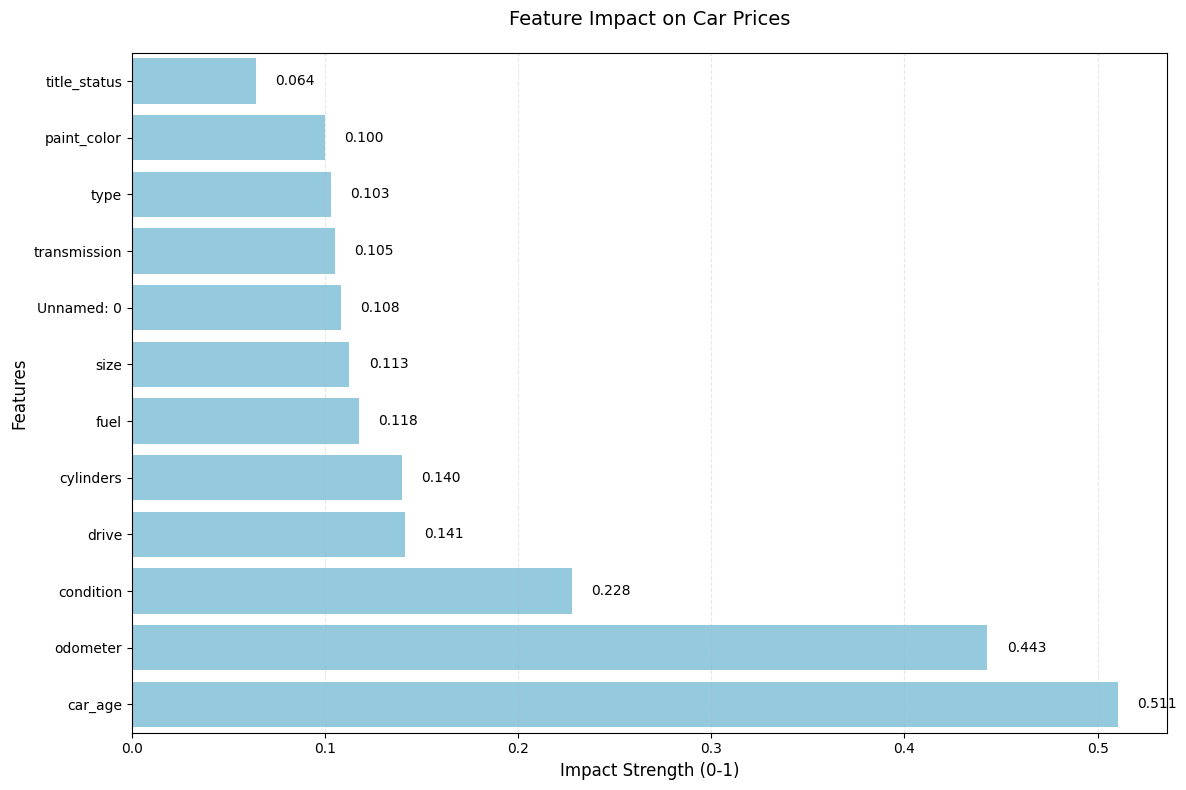

In [41]:
visualize_feature_analysis(results)
visualize_state_prices("data/state_price_factors.csv")
visualize_feature_impacts(model_correlations)